# Employee Review Analysis - Part 2 - Sentiment Analysis
#### Dataset:
This dataset is about a company's employee review and it was scrapped from Glassdoor. The usage of this datset has been approved by Glassdoor in written.

## Introduction
This is part 2 of the employee review analysis. In this section, we are going to do further exploration by getting the top words, and use NLP to do sentiment analysis.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from collections import Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk
import spacy
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import re
from os import path
from PIL import Image
import plotly
from sklearn.feature_extraction.text import CountVectorizer


Bad key "text.kerning_factor" on line 4 in
c:\anaconda3\envs\py36\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
df_cleaned = pd.read_csv('df_cleaned.csv')
df_cleaned.head(2)

,Comment Datetime,State,Job Title,Tenure,Current Employee,Full-time,Summary,Pro,Con,Recommended,Positive Outlook,Approves of CEO,Overall Rating,Career Opportunities,Compensation and Benefits,Work/Life Balance,Senior Management,Culture & Values
0,2008-06-11,MA,Director,NaN,1,NaN,"""very political""",privately owned company that can look at long ...,risk averse management that does not know how ...,-1,0,0,2.0,2.0,2.5,3.5,2.5,NaN
1,2008-06-11,MA,Vice President,NaN,0,NaN,"""Great Brand-Name But Caveat Emptor""",Industry leader in many ways with one of the b...,"A lot of uncertainty from the top down, and mo...",0,0,0,3.0,4.0,3.5,1.0,1.5,NaN


## Preliminary Text Analysis

#### The Most Common Words Displayed in Table
A quick glance at the most common words gives insights not only on the frequently used words but also words that could also be potential data specific stop words. We are going to use Python NLTK package's word_tokenize class.

In [3]:
# define a funtion to get the most n commonly used words

def get_common_words(column,n):
    text = df_cleaned[column].to_string()
    tokens = [w for w in word_tokenize(text.lower()) if w.isalpha()]
    no_stops = [t for t in tokens if t not in stopwords.words('english')]
    top_n = Counter(no_stops).most_common(n)
    
    return top_n

In [4]:
# get top 20 words in column 'Summary'

top_20_summary = get_common_words('Summary',20)
pd.DataFrame(top_20_summary, columns=['Word','Count']).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Word,great,company,work,good,place,anonymous,financial,benefits,representative,engineer,analyst,software,manager,experience,career,culture,best,start,senior,associate
Count,1381,1058,1040,999,880,354,326,276,218,195,171,166,156,148,147,135,132,125,125,125


In [5]:
# get top 20 words in column 'Pro'

top_20_pro = get_common_words('Pro',20)
pd.DataFrame(top_20_pro, columns=['Word','Count']).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Word,great,good,benefits,work,company,people,culture,life,pay,balance,environment,place,anonymous,training,excellent,nice,opportunities,friendly,profit,best
Count,2188,1835,1805,1515,700,570,442,440,419,418,354,313,277,265,239,230,204,175,171,159


In [6]:
# get top 20 words in column 'Con'

top_20_con = get_common_words('Con',20)
pd.DataFrame(top_20_con, columns=['Word','Count']).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Word,work,management,pay,company,much,slow,many,cons,lot,growth,get,low,call,salary,politics,hard,center,nothing,job,career
Count,480,463,400,388,242,210,207,204,199,199,197,193,181,175,173,171,156,155,153,152


Looks like `work`,`place`,`anonymous` could be added to customized stop words.  (delete this!)

In [7]:
# creat a list of stop words by adding custom stopwords

stop_words = set(stopwords.words("english"))
cus_words = ["work", "place", "anonymous","anonymou","they","there"]
stop_words = stop_words.union(cus_words)

#### The Most Common Words Displayed in WordCloud

Use WordCloud to visually show the most commonly used words in each section. 

In [8]:
# defind a function to plot wordcloud

def plot_wordcloud(column):
    text = df_cleaned[column].to_string().lower()
    wordcloud = WordCloud(background_color='white',
                          stopwords = stop_words,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42).generate(text)

    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.title(column, fontsize=20)
    plt.show()

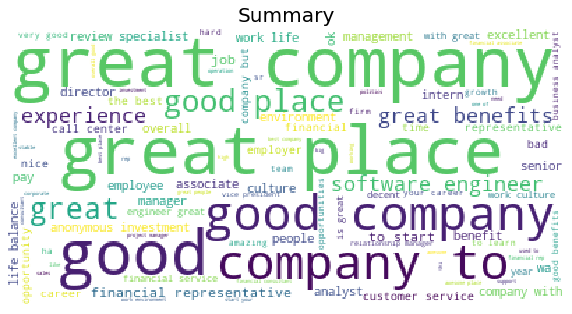

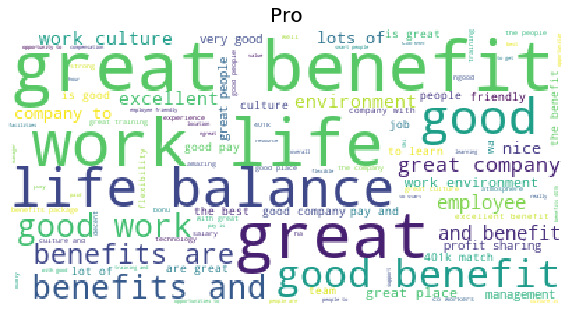

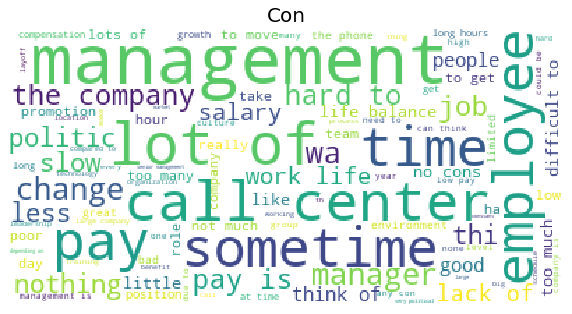

In [9]:
# plot 'Summary','Pro'and 'Cro' in wordcloud

for column_name in ['Summary', 'Pro', 'Con']:
    plot_wordcloud(column_name)

**Findings**: 
* The most common words in `Summary` is positive, which is consistent with our previous plot where 60% of employees recommend this company.
* Employees who love this company due to its great benefits and good work-life balance.
* It appears employees' complaint are mostly about management and the job nature of call center.

## Sentiment Analysis

**Sentiment Analysis with TextBlob:** 

Linguistic researchers have labeled the sentiment of words based on their domain expertise. Sentiment of words can vary based on where it is in a sentence. The TextBlob module allows us to take advantage of these labels.
Sentiment Labels: Each word in a corpus is labeled in terms of polarity and subjectivity (there are more labels as well, but we're going to ignore them for now). A corpus' sentiment is the average of these.
* Polarity: How positive or negative a word is. -1 is very negative. +1 is very positive.
* Subjectivity: How subjective, or opinionated a word is. 0 is fact. +1 is very much an opinion.

Since we know `Pro` is all postive and `Con' is negative, let's take a look at the sentiment of `Summary` column.

In [10]:
# sentiment analysis on column 'Summary'

from textblob import TextBlob

pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

df_cleaned['S_Polarity'] = df_cleaned['Summary'].apply(pol)
df_cleaned['S_Subjectivity'] = df_cleaned['Summary'].apply(sub)

df_cleaned[['Summary','S_Polarity','S_Subjectivity']]

,Summary,S_Polarity,S_Subjectivity
0,"""very political""",0.0,0.130
1,"""Great Brand-Name But Caveat Emptor""",0.8,0.750
2,"""Great place to work if you are not out all fo...",0.8,0.750
3,"""Anonymous - the good and not so good""",0.7,0.600
4,"""Why wouldn't you want to work here?""",0.0,0.000
...,...,...,...
6381,"""Great company to work with""",0.8,0.750
6382,"""Great place to work""",0.8,0.750
6383,"""WORST HR People & Culture""",-1.0,1.000
6384,"""Great people with confused management""",0.2,0.725


Look at row 6383. Textblob captured this strongly negative message and assigned polarity as -1. Row 6384 starts with a positive word but followed with negative word 'confused management', Textblob also captured this sentiment correctly.

In [11]:
df_cleaned.loc[6383,'Comment Datetime']

print(df_cleaned.loc[6383,'Con'])

- HR are totally non-technical and have no Business knowledge

- Most of the HR team members are very dumb from top to bottom... 

- They are very biased in nature

- HR teams only make noises at social media about fidelity culture, gender diversity and innovation culture but the fact is they are dumb and don;t really understand any of this...

- HR policies are only on paper and nothing get really practiced...


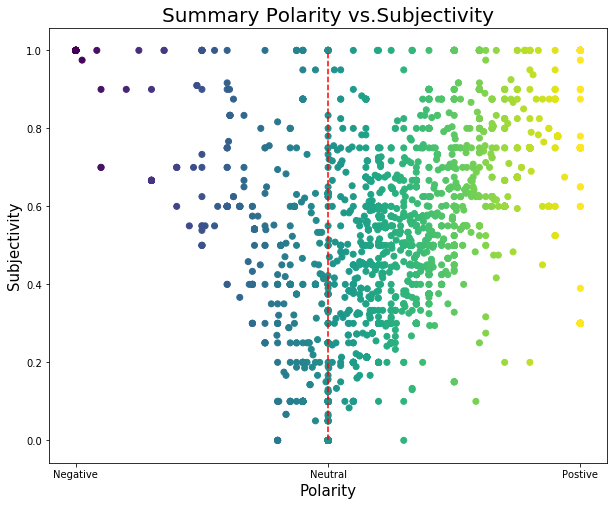

In [12]:
# plot the summary polarity and subjectivity

ax,figure = plt.subplots(figsize=(10,8))
plt.scatter(x='S_Polarity',y='S_Subjectivity', data=df_cleaned,c='S_Polarity')
plt.vlines(x=0, ymin=0, ymax=1, linestyles='dashed',colors='r')
plt.title('Summary Polarity vs.Subjectivity', fontsize=20)
plt.xlabel('Polarity',fontsize=15)
plt.ylabel('Subjectivity',fontsize=15)
plt.xticks([-1.00,0,1.00],['Negative','Neutral','Postive'])
plt.show()

**Findings:**

* It is clear that there are more positive comments than negative as we see more datapoints on the right side of the red verticle line. This verified what we have observed from precious EDA. 
* The more polarized the comment is (either postive or negative), the more subjective it is. 
* We also notice that reviewers who give postive comments based more on facts (lower subjectivity) and reviewers who give negative comments based more on opinion.

#### Plot Most Frequent 10 Job Titles' Sentiment

In [13]:
most_10_job = df_cleaned['Job Title'].value_counts().nlargest(10)
most_10_job

Anonymous Employee                   1578
Unknown Title                         980
Software Engineer                     309
Financial Representative              227
Director                              127
Vice President                        109
Project Manager                        93
Financial Services Representative      91
Manager                                81
Business Analyst                       81
Name: Job Title, dtype: int64

**Additional Data Cleaning**

Notice there are 'Financial Representative' and 'Financial Services Representative', 'Software Engineer' and 'Software Engineer/Developer'. Based on business knowledge, we assume these are the variants of the same job. Therefore, we are going to do additional cleaning by combining these 2 titles into 1.

In [14]:
# combine the 2 job titles into 1
df_cleaned['Job Title'] = df_cleaned['Job Title'].str.replace('Financial Services Representative', 'Financial Representative')
df_cleaned['Job Title'] = df_cleaned['Job Title'].str.replace('Software Engineer/Developer', 'Software Engineer')

# get the most frequent 10 job titles
most_10_job_list= df_cleaned['Job Title'].value_counts().nlargest(10).index.to_list()

# get the mean polarity and mean subjectivity of reviewers with the most frequent 10 job titles
sent_by_job = df_cleaned.groupby('Job Title')["S_Polarity", "S_Subjectivity"].mean()

# subset the polarity and subjectivity of the most frequent 10 job titles
sent_by_most10_job = sent_by_job.loc[most_10_job_list]

sent_by_most10_job


,S_Polarity,S_Subjectivity
Job Title,,
Anonymous Employee,0.263195,0.303966
Unknown Title,0.299251,0.356895
Software Engineer,0.363015,0.427079
Financial Representative,0.257664,0.376497
Director,0.302742,0.415075
Vice President,0.301023,0.452968
Project Manager,0.279923,0.395345
Business Analyst,0.340373,0.386558
Manager,0.341555,0.422964


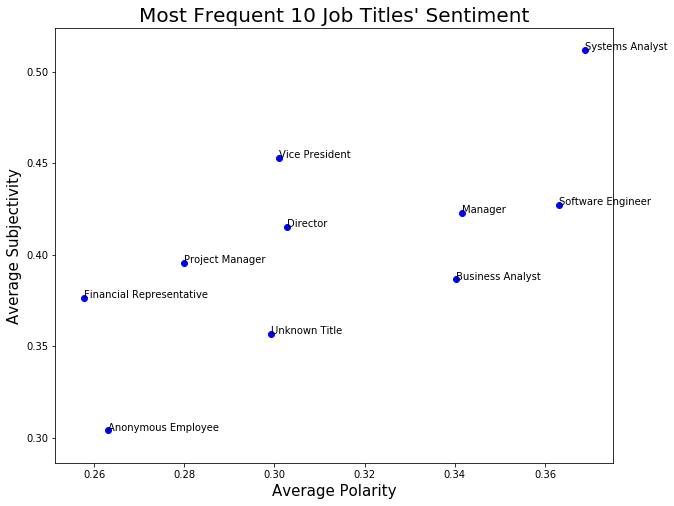

In [15]:
# plot the polarity and subjectivity of the most frequent 10 job titles

plt.rcParams['figure.figsize'] = [10, 8]

for i in sent_by_most10_job.index:
    x = sent_by_most10_job.loc[i,'S_Polarity']
    y = sent_by_most10_job.loc[i,'S_Subjectivity']
    plt.scatter(x, y, color='blue')
    plt.text(x, y, i, fontsize=10)

plt.title("Most Frequent 10 Job Titles' Sentiment", fontsize=20)
plt.xlabel('Average Polarity', fontsize=15)
plt.ylabel('Average Subjectivity', fontsize=15)

plt.show()

**Findings**:

* Financial Representatives and reviewers who do not disclose their title (Anonyumous Employee) tend to give the most negative comments in 'Summary'. 
* System Analysts and Software Engineers have the most postive comments.

Next, in Part 3, we are going to do topic modeling.